## Import

In [1]:
import numpy as np
import pandas as pd
import warnings; warnings.filterwarnings("ignore")

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

## Read Data

In [2]:
data_path = '../data/'

pdde = pd.read_csv(data_path+"DC_LPOINT_PDDE.csv")          # [DC] 유통사 상품 구매 내역
br = pd.read_csv(data_path+"LPOINT_BIG_COMP_05_BR.csv")     # 유통사/제휴사 점포 마스터

In [3]:
trade = pdde.groupby(['cust','cop_c','chnl_dv','br_c','de_dt','date'])\
        .agg({'rct_no':[('영수증수', np.size)],'pd_c':[('상품종류수', pd.Series.nunique)],
              'buy_am':[('금액', sum)],'buy_ct':[('수량', sum)]})
trade.columns = trade.columns.get_level_values(1) ; trade.reset_index(inplace=True)

trade = trade.merge(pdde[['cust','br_c','home','store']].fillna(0).drop_duplicates(), on=['cust','br_c'], how='left')
display(trade.sample(5))

,cust,cop_c,chnl_dv,br_c,de_dt,date,영수증수,상품종류수,금액,수량,home,store
525018,M539281688,A01,1,A010037,2021-07-19,2021-07-19 15:00:00,1,1,164000.0,1,Z04,Z04
764943,M786149408,A02,1,A020008,2021-12-25,2021-12-25 18:00:00,6,6,31710.0,6,Z17,Z17
222086,M225759092,A02,1,A020025,2021-03-20,2021-03-20 10:00:00,13,12,51010.0,17,Z10,Z10
819527,M840374708,A03,1,A030069,2021-08-21,2021-08-21 22:00:00,3,3,4270.0,6,Z08,Z08
29118,M029877095,A01,1,A010018,2021-03-27,2021-03-27 19:00:00,4,2,502000.0,4,Z14,Z14


## 거주지 내/외 구매

- 거주지와 매장위치간의 비교
  - 거주지 내 구매의 평균구매수량이 높은 것을 보아 차량을 이용하여 매장을 이용할 가능성이 있다.
  - 유의미한 차이로 거주지 외에서 구매할 때 평균금액이 높다.
  - Z02의 A01 매장에서 상품 묶음 행사 등의 마케팅으로 타지역인 Z02로 이동해 많은 수량의 상품을 구매한 것일 수 있다.
  - Z04, Z03에는 A01 매장이 적음에도 거주지 내 구매 중 A01 이용률이 꽤 되며 평균금액이 매우 높다.

In [4]:
ease = trade[trade['home']==trade['store']]
ease['거주지내구매'] = 1

trade = pd.merge(trade, ease['거주지내구매'], left_index=True, right_index=True, how='outer')
trade['거주지내구매'].fillna(0, inplace=True)

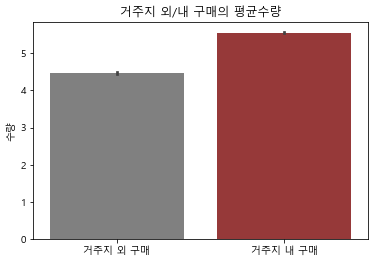

In [5]:
sns.barplot(data=trade, x='거주지내구매', y='수량', palette=['gray','brown'])
plt.title("거주지 외/내 구매의 평균수량")
plt.xticks([0,1],['거주지 외 구매', '거주지 내 구매'])
plt.xlabel('')
plt.show()

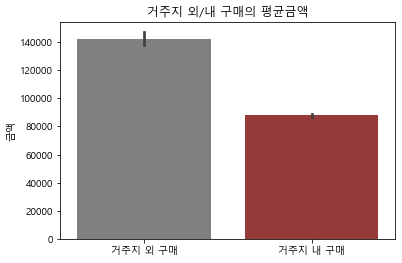

In [6]:
sns.barplot(data=trade, x='거주지내구매', y='금액', palette=['gray','brown'])
plt.title("거주지 외/내 구매의 평균금액")
plt.xticks([0,1],['거주지 외 구매', '거주지 내 구매'])
plt.xlabel('')
plt.show()

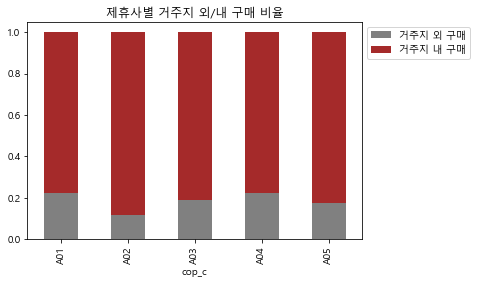

In [7]:
use = pd.pivot_table(trade, index='cop_c', columns='거주지내구매', values='수량', aggfunc=np.size, margins=True)
use.divide(use['All'], axis=0).iloc[:-1, :-1].plot.bar(stacked=True, title="제휴사별 거주지 외/내 구매 비율", color=['gray','brown'])
plt.legend(['거주지 외 구매', '거주지 내 구매'],  bbox_to_anchor=(1,1))
plt.show()

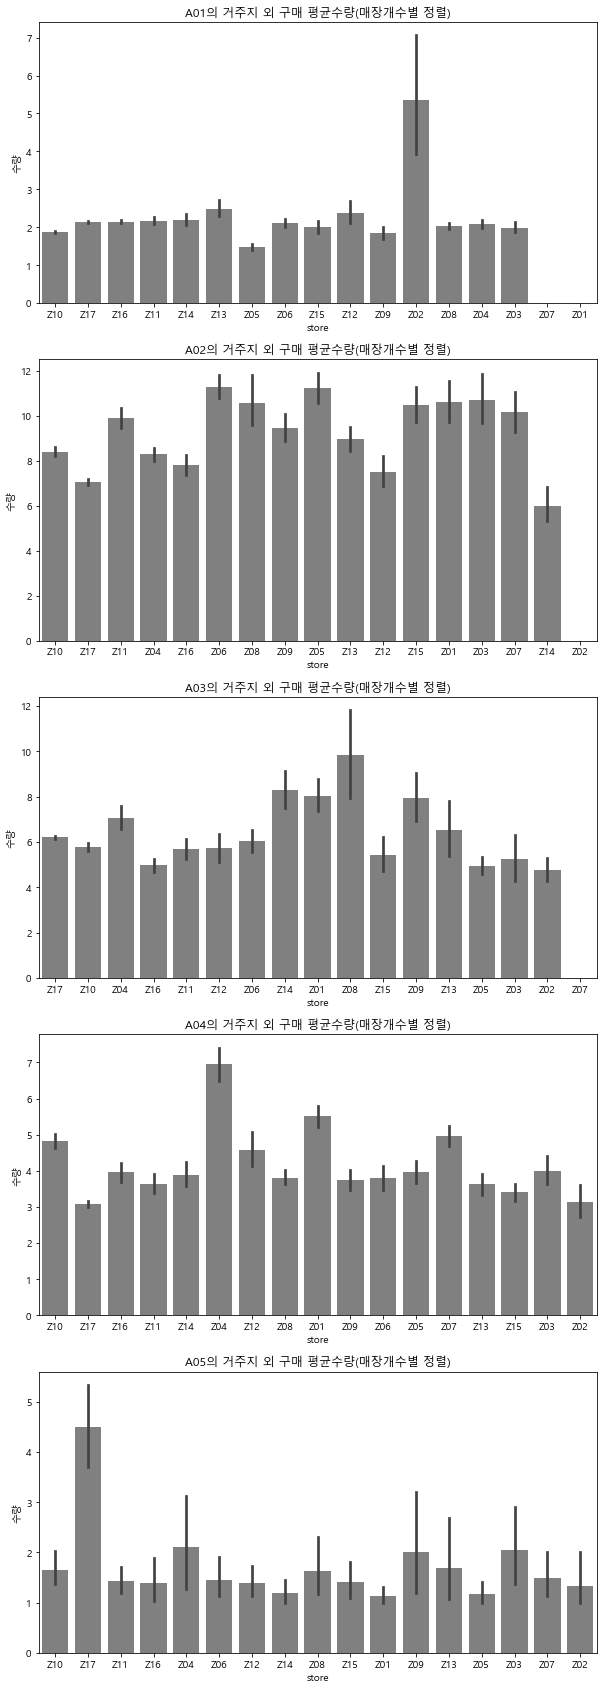

In [8]:
br_rank = pd.pivot_table(br, index='zon_hlv', columns='cop_c', values='br_c', aggfunc=np.size, fill_value=0)\
          [[i for i in br.cop_c.unique() if i[0]=="A"]]

fig, ax = plt.subplots(5,1, figsize=(10,30))
for COP in br_rank.columns:
    sns.barplot(data=trade.query('거주지내구매==0 & cop_c==@COP'), 
                x='store', y='수량', order=br_rank[COP].sort_values(ascending=False).index, 
                color='gray', ax=ax[br_rank.columns.tolist().index(COP)])
    ax[br_rank.columns.tolist().index(COP)].set_title(f'{COP}의 거주지 외 구매 평균수량(매장개수별 정렬)')
plt.show()

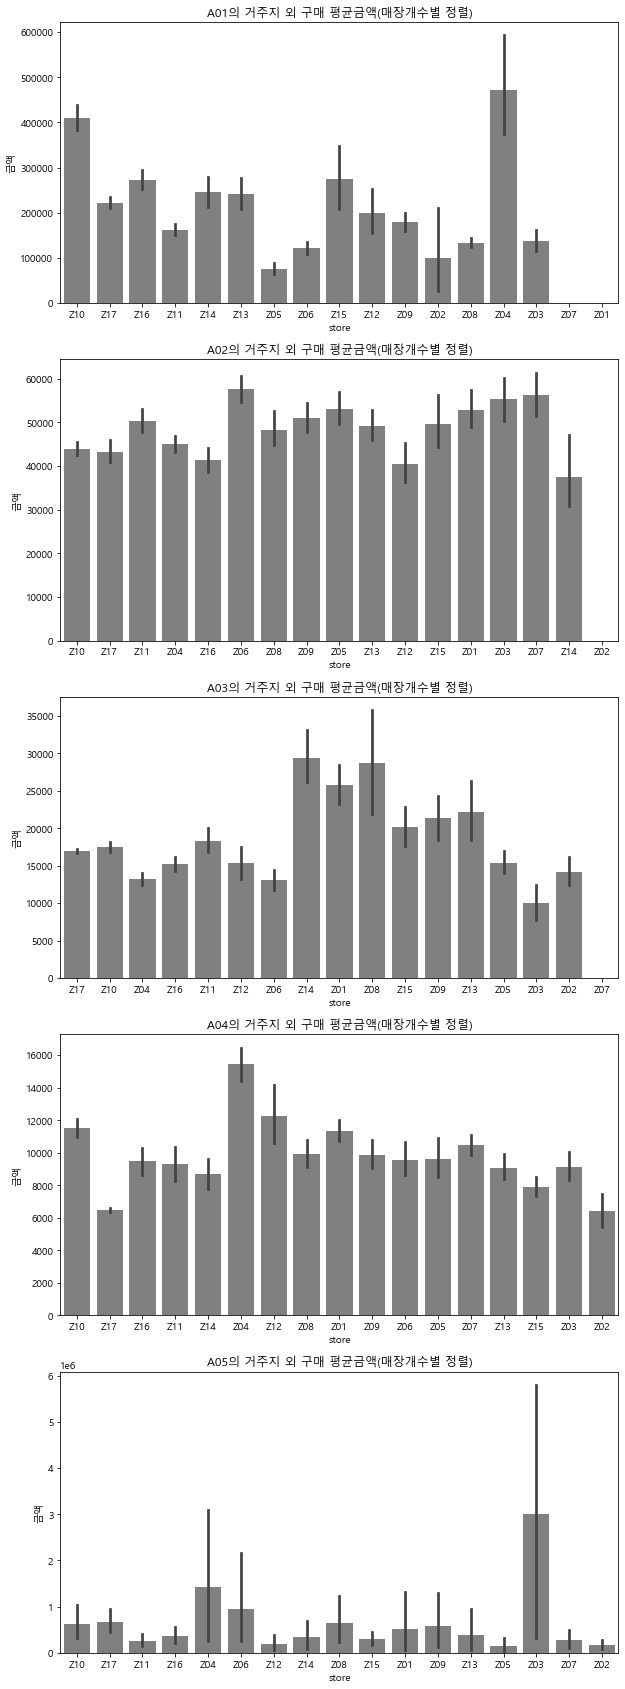

In [9]:
fig, ax = plt.subplots(5,1, figsize=(10,30))
for COP in br_rank.columns:
    sns.barplot(data=trade.query('거주지내구매==0 & cop_c==@COP'), 
                x='store', y='금액', order=br_rank[COP].sort_values(ascending=False).index, 
                color='gray', ax=ax[br_rank.columns.tolist().index(COP)])
    ax[br_rank.columns.tolist().index(COP)].set_title(f'{COP}의 거주지 외 구매 평균금액(매장개수별 정렬)')
plt.show()

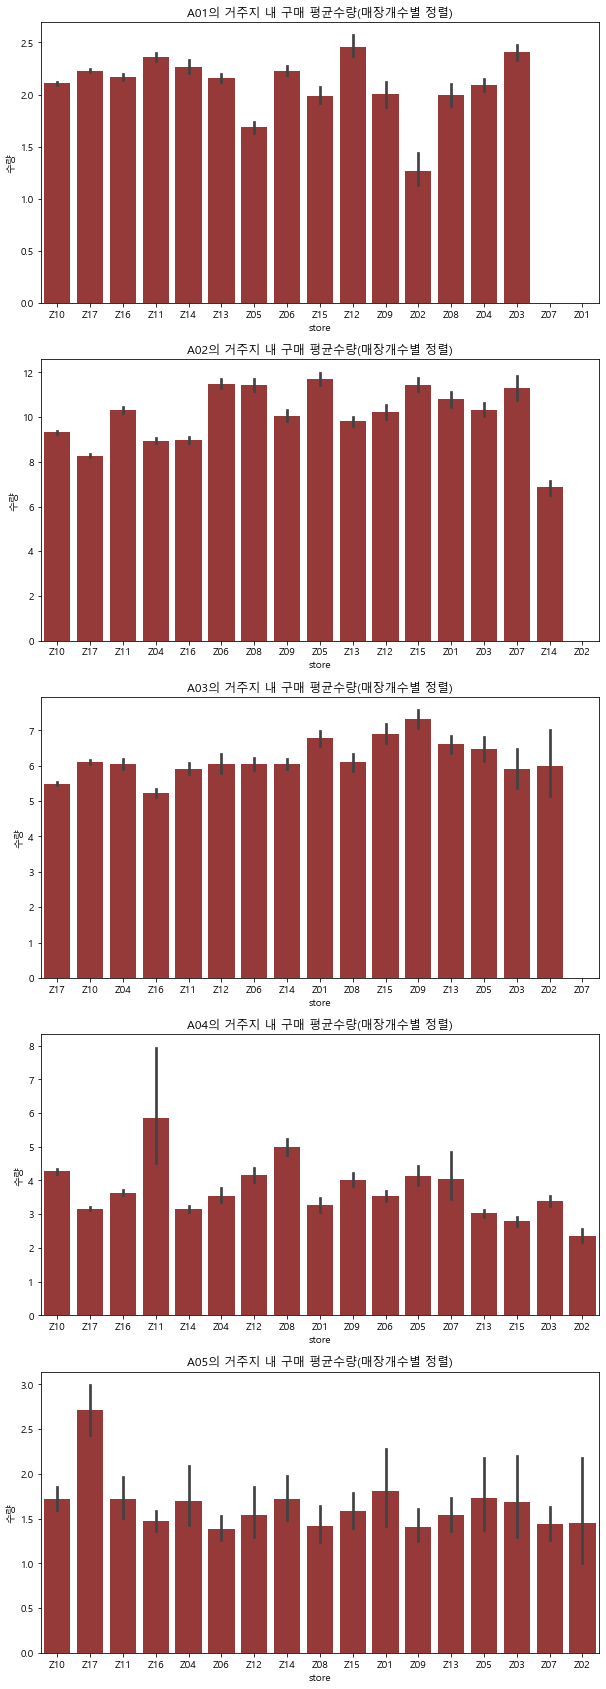

In [10]:
fig, ax = plt.subplots(5,1, figsize=(10,30))
for COP in br_rank.columns:
    sns.barplot(data=trade.query('거주지내구매==1 & cop_c==@COP'), 
                x='store', y='수량', order=br_rank[COP].sort_values(ascending=False).index, 
                color='brown', ax=ax[br_rank.columns.tolist().index(COP)])
    ax[br_rank.columns.tolist().index(COP)].set_title(f'{COP}의 거주지 내 구매 평균수량(매장개수별 정렬)')
plt.show()

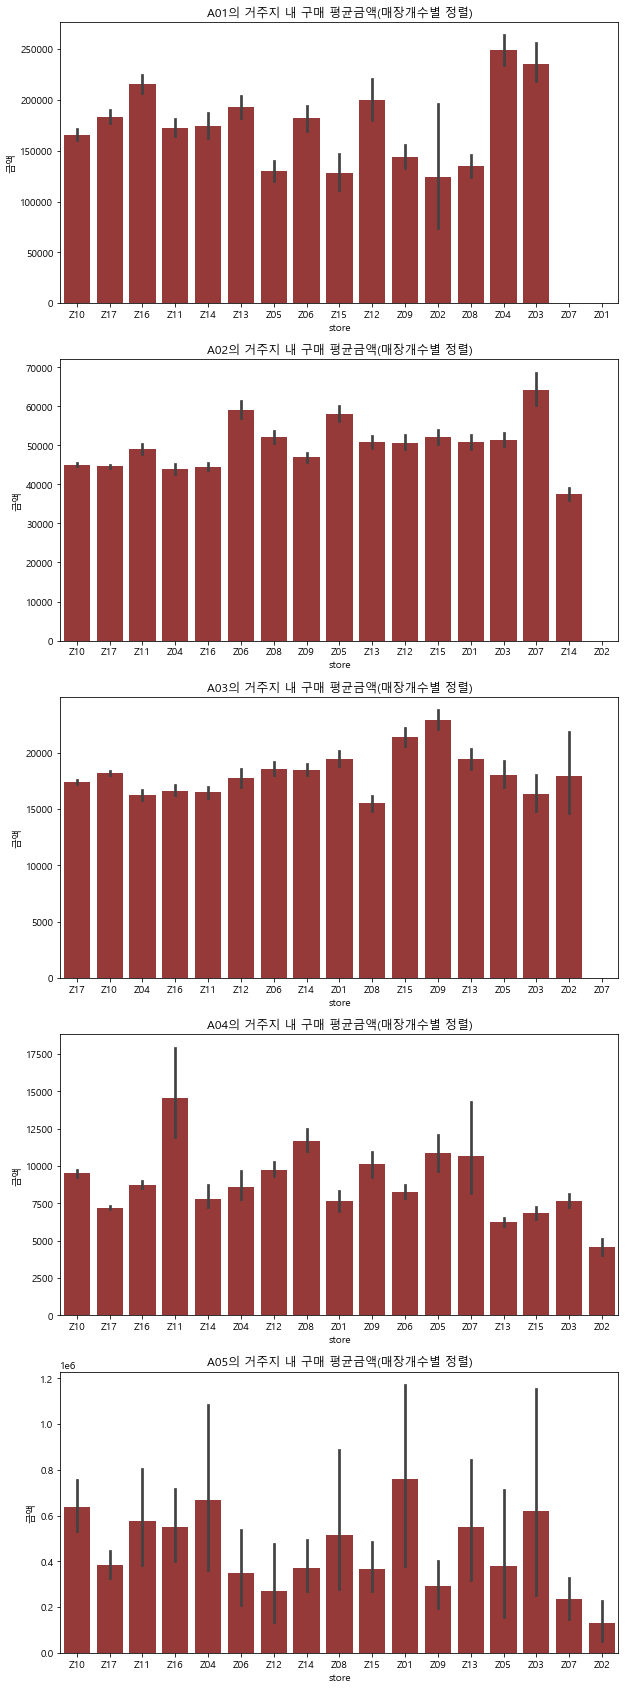

In [11]:
fig, ax = plt.subplots(5,1, figsize=(10,30))
for COP in br_rank.columns:
    sns.barplot(data=trade.query('거주지내구매==1 & cop_c==@COP'), 
                x='store', y='금액', order=br_rank[COP].sort_values(ascending=False).index, 
                color='brown', ax=ax[br_rank.columns.tolist().index(COP)])
    ax[br_rank.columns.tolist().index(COP)].set_title(f'{COP}의 거주지 내 구매 평균금액(매장개수별 정렬)')
plt.show()

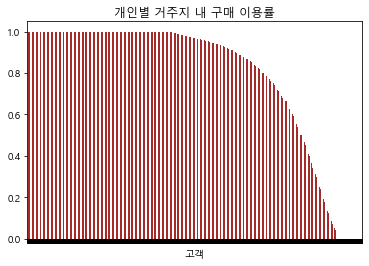

In [12]:
# 고객번호로 인해 출력물이 더러워서 변경하였다.
ease = trade.groupby('cust')['거주지내구매'].mean().reset_index(drop=True).sort_values(ascending=False)
ease.index = ['']*ease.shape[0]
ease.plot.bar(title="개인별 거주지 내 구매 이용률", color='brown')
plt.xlabel('고객')
plt.show()